# TTC Line 2 Arrival Time by Bohan

### Goal
This file merges responses.csv and requests.csv and outputs cleansed data for arrivial time of each train at each station.  
It can be applied to other subway lines as well.

### Issues (Fixed)
1. Size of requests and responses did not match
2. Duplicates (based on requestid) were found after merging
3. There might be missing data (see last graph)  

### Things improved
1. Remove Trains that are outside of service time
2. The same train should not be at 2 stations at the same time
    - Trains arriving between 0 to 2min(new) were included
    - New method to include more possible combinations (i.e. trains arriving in two directions at terminals)
3. Switch station id for transfer stations

#### It makes basic explation on the simple data set

In [1]:
import numpy as np;  # useful for many scientific computing in Python
import pandas as pd; # primary data structure library
import datetime; # datetime data

# data from 201907.zip were used
responses = pd.read_csv('responses.csv'); # import file
requests = pd.read_csv('requests.csv'); # import file

# merge two dataframes
df = pd.merge(left=responses, right=requests, left_on='requestid',
                  right_on='requestid');

#### Select Line 2 trains At Station

In [2]:
## Line 2 (BD) trains
trains_BD = df[df['subwayline'] == 'BD'].copy();

# separate date and time
r_date = pd.to_datetime(trains_BD['request_date']);

trains_BD['date'] = r_date.dt.date;
trains_BD['time'] = r_date.dt.time;

#### Take data from 6am to 1:30am everyday

In [3]:
# On weekdays and Saturdays, trains run from about 6 a.m. until 1:30 a.m. 
# On Sundays, they run from about 8 a.m. to 1:30 a.m.
# Take data from 6am to 1:30am everyday

trains_BD = trains_BD[(trains_BD['time']>=datetime.time( 6,0,0 )) |
                      (trains_BD['time']<=datetime.time( 1,30,0 )) ];

#### Find arrival time and separate date and time
#### And remove duplicates based on requestid

In [4]:
# Find trains at station
trains_BD_AtStation = trains_BD[trains_BD['train_message'] == 'AtStation'];

# Find trains arriving between 0 to 2 min exclusive
trains_BD_Delayed = trains_BD[(trains_BD['train_message'] == 'Delayed') &
                              (trains_BD['timint'] <2) &
                              (trains_BD['timint'] >0)];

trains_BD_Arriving = trains_BD[(trains_BD['train_message'] == 'Arriving') &
                              (trains_BD['timint'] <2) &
                              (trains_BD['timint'] >0)];

#### Merge three dataframes and remove duplicates when trains are at station

In [5]:
## Concatenate three dataframes
merged = pd.concat([trains_BD_AtStation, trains_BD_Arriving], axis=0);
merged = pd.concat([merged, trains_BD_Delayed], axis=0);

# select one example train
train201=merged[(merged['trainid'] == 201) & (merged['date'] == datetime.date(2019,7,7))];

In [6]:
train201[train201['station_char']=='KIP1']

,requestid,id,station_char,subwayline,system_message_type,timint,traindirection,trainid,train_message,train_dest,data_,stationid,lineid,all_stations,create_date,pollid,request_date,date,time
198318,38612,31844781936,KIP1,BD,Normal,0.000000,East,201,AtStation,Westbound<br/> To Kipling,NaN,33,2,success,2019-07-07 17:49:16,552,2019-07-07 17:49:17.054748-04:00,2019-07-07,17:49:17.054748
199477,38827,31844707836,KIP1,BD,Normal,0.000000,East,201,AtStation,Westbound<br/> To Kipling,NaN,33,2,success,2019-07-07 17:46:14,555,2019-07-07 17:46:15.165195-04:00,2019-07-07,17:46:15.165195
199863,38899,31844684827,KIP1,BD,Normal,0.000000,East,201,AtStation,Westbound<br/> To Kipling,NaN,33,2,success,2019-07-07 17:45:16,556,2019-07-07 17:45:16.661738-04:00,2019-07-07,17:45:16.661738
200262,38971,31844660752,KIP1,BD,Normal,0.000000,East,201,AtStation,Westbound<br/> To Kipling,NaN,33,2,success,2019-07-07 17:44:14,557,2019-07-07 17:44:15.163928-04:00,2019-07-07,17:44:15.163928
200663,39043,31844636566,KIP1,BD,Normal,0.000000,East,201,AtStation,Westbound<br/> To Kipling,NaN,33,2,success,2019-07-07 17:43:13,558,2019-07-07 17:43:14.179929-04:00,2019-07-07,17:43:14.179929
241427,46579,31842167414,KIP1,BD,Normal,0.000000,East,201,AtStation,Westbound<br/> To Kipling,NaN,33,2,success,2019-07-07 15:58:15,663,2019-07-07 15:58:15.607496-04:00,2019-07-07,15:58:15.607496
241814,46651,31842143335,KIP1,BD,Normal,0.000000,East,201,AtStation,Westbound<br/> To Kipling,NaN,33,2,success,2019-07-07 15:57:12,664,2019-07-07 15:57:14.031067-04:00,2019-07-07,15:57:14.031067
242209,46723,31842121467,KIP1,BD,Normal,0.000000,East,201,AtStation,Westbound<br/> To Kipling,NaN,33,2,success,2019-07-07 15:56:15,665,2019-07-07 15:56:16.324415-04:00,2019-07-07,15:56:16.324415
242592,46795,31842097826,KIP1,BD,Normal,0.000000,East,201,AtStation,Westbound<br/> To Kipling,NaN,33,2,success,2019-07-07 15:55:15,666,2019-07-07 15:55:16.056597-04:00,2019-07-07,15:55:16.056597
283084,54270,31839710822,KIP1,BD,Normal,0.000000,East,201,AtStation,Westbound<br/> To Kipling,NaN,33,2,success,2019-07-07 14:11:13,770,2019-07-07 14:11:14.349717-04:00,2019-07-07,14:11:14.349717


In [7]:
train201[train201['station_char']=='KIP2']

,requestid,id,station_char,subwayline,system_message_type,timint,traindirection,trainid,train_message,train_dest,data_,stationid,lineid,all_stations,create_date,pollid,request_date,date,time
120512,24243,31849253415,KIP2,BD,Normal,0.000000,West,201,AtStation,Westbound<br/> To Kipling,NaN,33,2,success,2019-07-07 21:09:16,352,2019-07-07 21:09:17.044144-04:00,2019-07-07,21:09:17.044144
120896,24314,31849232488,KIP2,BD,Normal,0.000000,West,201,AtStation,Westbound<br/> To Kipling,NaN,33,2,success,2019-07-07 21:08:16,353,2019-07-07 21:08:18.174899-04:00,2019-07-07,21:08:18.174899
159422,31426,31847080709,KIP2,BD,Normal,0.000000,West,201,AtStation,Westbound<br/> To Kipling,NaN,33,2,success,2019-07-07 19:29:12,452,2019-07-07 19:29:14.393293-04:00,2019-07-07,19:29:14.393293
159811,31498,31847058870,KIP2,BD,Normal,0.000000,West,201,AtStation,Westbound<br/> To Kipling,NaN,33,2,success,2019-07-07 19:28:15,453,2019-07-07 19:28:16.110437-04:00,2019-07-07,19:28:16.110437
121284,24385,31849215123,KIP2,BD,Normal,0.425776,West,201,Arriving,Eastbound<br/> To Kennedy,NaN,33,2,success,2019-07-07 21:07:23,354,2019-07-07 21:07:23.643545-04:00,2019-07-07,21:07:23.643545
121677,24456,31849195574,KIP2,BD,Normal,1.229769,West,201,Arriving,Eastbound<br/> To Kennedy,NaN,33,2,success,2019-07-07 21:06:23,355,2019-07-07 21:06:24.266846-04:00,2019-07-07,21:06:24.266846
160204,31570,31847039181,KIP2,BD,Normal,0.348774,West,201,Arriving,Eastbound<br/> To Kennedy,NaN,33,2,success,2019-07-07 19:27:19,454,2019-07-07 19:27:20.284202-04:00,2019-07-07,19:27:20.284202
160592,31642,31847016268,KIP2,BD,Normal,1.229769,West,201,Arriving,Eastbound<br/> To Kennedy,NaN,33,2,success,2019-07-07 19:26:16,455,2019-07-07 19:26:16.437294-04:00,2019-07-07,19:26:16.437294
201059,39115,31844613830,KIP2,BD,Normal,1.229769,West,201,Arriving,Eastbound<br/> To Kennedy,NaN,33,2,success,2019-07-07 17:42:14,559,2019-07-07 17:42:15.738367-04:00,2019-07-07,17:42:15.738367
201451,39187,31844590223,KIP2,BD,Normal,1.532399,West,201,Arriving,Eastbound<br/> To Kennedy,NaN,33,2,success,2019-07-07 17:41:14,560,2019-07-07 17:41:15.349530-04:00,2019-07-07,17:41:15.349530


We can see that this train (last row on 2019-07-07 12:20:17.159036) is classified as  
arriving for both directions at Kipling terminal station.  
I will include only one of them in the next section.

#### Remove duplicates (i.e. a train should not be at two different stations at the same time
  
1. Sort based on Time remaining until train arrives at station (timint) and train_message in the order to keep the ones first appear on the top
2. Remove duplicates from the bottom

In [8]:
# If trains are arriving or delayed in two stations, 
# keep the one takes shorter time to arrive or the first one

# sort based on Time remaining until train arrives at station (timint)
merged = pd.concat((trains_BD_AtStation.sort_values(
        by=['timint']), trains_BD_Arriving.sort_values(by=['timint'])), axis=0);
        
merged = pd.concat((merged, trains_BD_Delayed.sort_values(
        by=['timint'])), axis=0);
l1 = len(merged); # store length for comparison

## Now it should be in the order AtStation / timint(ascending) -> Arriving / timint(ascending) -> Delayed / timint(ascending)
# remove duplicates
merged.drop_duplicates(subset=['trainid','create_date'],keep='first',inplace=True);

print('Number of duplicates = ', l1-len(merged));

Number of duplicates =  20049


#### Check for duplicates by trainid and create_date (should be empty)

In [9]:
merged[merged.duplicated(subset=['trainid','create_date'], keep=False)]

,requestid,id,station_char,subwayline,system_message_type,timint,traindirection,trainid,train_message,train_dest,data_,stationid,lineid,all_stations,create_date,pollid,request_date,date,time


#### Switch stationid and edit station_char, then sort

In [10]:
# Switch stationid
merged.loc[df['stationid'] == 9, 'stationid'] = 47;
merged.loc[df['stationid'] == 10, 'stationid'] = 48;
merged.loc[df['stationid'] == 22, 'stationid'] = 50;

# remove directionality in station_char
merged['station_char'] = merged['station_char'].str[:-1];

# sort
merged.sort_values(by=['date','trainid','time'], inplace=True);


#### Check and Remove unnecessary columns

In [11]:
# check system_message_type to be Normal
a = sorted(merged['system_message_type']);
if a[0] == a[-1]:
    merged.drop(['system_message_type'],axis=1, inplace=True);
else:
    print('system_message_type coloumn is not all Normal');

# check data_ to be nan
if np.isnan(np.min(merged['data_'])):
    merged.drop(['data_'],axis=1, inplace=True);
else:
    print('data_ coloumn is not all nan');
    
# check all_stations to be success
a = sorted(merged['all_stations']);
if a[0] == a[-1]:
    merged.drop(['all_stations'],axis=1, inplace=True);
else:
    print('all_stations coloumn is not all success');

### Plot behaviour of one train

In [12]:
# plotting
import matplotlib.pyplot as plt

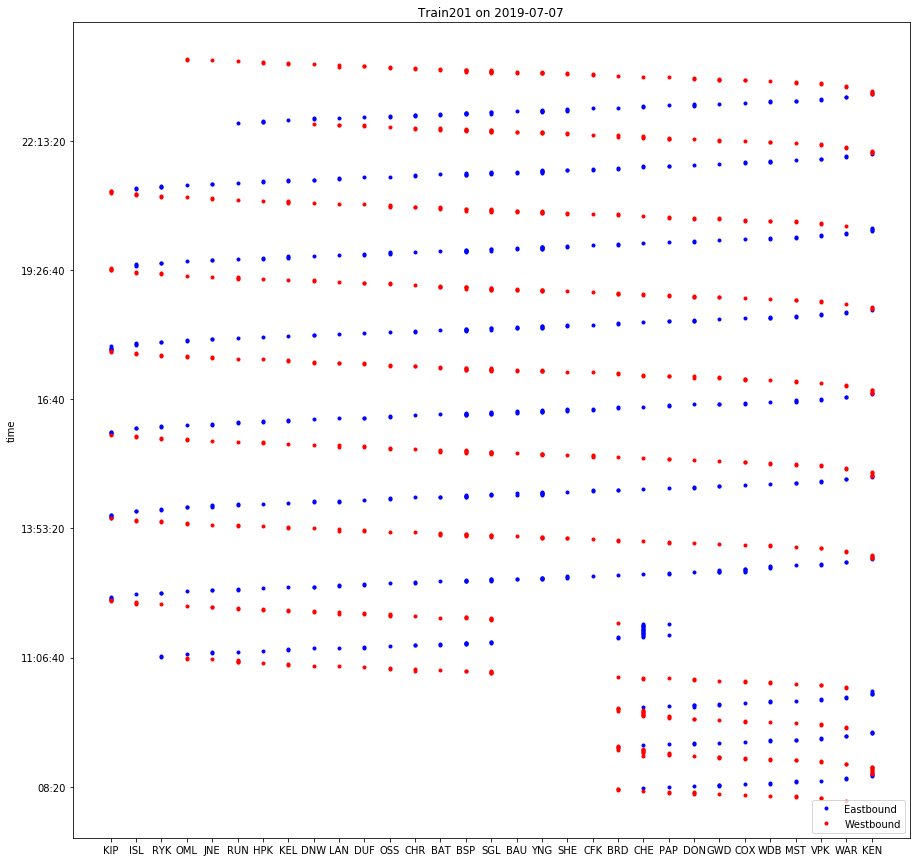

In [13]:
plt.figure(figsize=(15, 15))
train = 201;
day = datetime.date(2019,7,7);
plt.plot(merged[(merged['trainid'] == train) & (merged['traindirection'] == 'East') &
                (merged['date'] == day)]['stationid'],
        merged[(merged['trainid'] == train) & (merged['traindirection'] == 'East') &
                (merged['date'] == day)]['time'],'b.', label='Eastbound')

plt.plot(merged[(merged['trainid'] == train) & (merged['traindirection'] == 'West') &
                (merged['date'] == day)]['stationid'],
        merged[(merged['trainid'] == train) & (merged['traindirection'] == 'West') &
                (merged['date'] == day)]['time'],'r.', label='Westbound')
plt.xticks(merged['stationid'].unique(), merged['station_char'].unique())
plt.title('Train'+str(train)+' on '+str(day))
plt.legend(loc='lower right')
plt.show()

#### Note: 
1. Darker dot indicates a train stayed for longer than 1 min.
2. My graph contains more data points than Rami's
3. Most obvious ones are BAT(46) around 12 and CFK(52) around 16:30

In [14]:
# Data in the graph
# Eastbound
merged[(merged['trainid'] == train) & (merged['traindirection'] == 'East') & (merged['date'] == day)]

,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,stationid,lineid,create_date,pollid,request_date,date,time
403551,78711,31832256283,CHE,BD,0.000000,East,201,AtStation,Westbound<br/> To Kipling,54,2,2019-07-07 08:18:46,1123,2019-07-07 08:18:47.718144-04:00,2019-07-07,08:18:47.718144
403258,78645,31832275707,PAP,BD,0.000000,East,201,AtStation,Westbound<br/> To Kipling,55,2,2019-07-07 08:19:57,1122,2019-07-07 08:19:58.262058-04:00,2019-07-07,08:19:58.262058
402979,78582,31832289196,DON,BD,0.683677,East,201,Arriving,Westbound<br/> To Kipling,56,2,2019-07-07 08:20:40,1121,2019-07-07 08:20:41.857084-04:00,2019-07-07,08:20:41.857084
402982,78583,31832289253,GWD,BD,1.813443,East,201,Arriving,Westbound<br/> To Kipling,57,2,2019-07-07 08:20:41,1121,2019-07-07 08:20:42.246950-04:00,2019-07-07,08:20:42.246950
402692,78515,31832306462,GWD,BD,0.874767,East,201,Arriving,Westbound<br/> To Kipling,57,2,2019-07-07 08:21:43,1120,2019-07-07 08:21:43.993656-04:00,2019-07-07,08:21:43.993656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75583,15909,31851782334,VPK,BD,1.164091,East,201,Arriving,Westbound<br/> To Kipling,61,2,2019-07-07 23:06:24,235,2019-07-07 23:06:25.839166-04:00,2019-07-07,23:06:25.839166
75193,15838,31851806002,VPK,BD,0.000000,East,201,AtStation,Westbound<br/> To Kipling,61,2,2019-07-07 23:07:30,234,2019-07-07 23:07:30.846388-04:00,2019-07-07,23:07:30.846388
74421,15696,31851848848,WAR,BD,1.175131,East,201,Arriving,Westbound<br/> To Kipling,62,2,2019-07-07 23:09:27,232,2019-07-07 23:09:27.859417-04:00,2019-07-07,23:09:27.859417
74027,15624,31851871051,WAR,BD,0.000000,East,201,AtStation,Westbound<br/> To Kipling,62,2,2019-07-07 23:10:28,231,2019-07-07 23:10:29.094293-04:00,2019-07-07,23:10:29.094293


In [15]:
# Data in the graph
# Westbound
merged[(merged['trainid'] == train) & (merged['traindirection'] == 'West') & (merged['date'] == day)]

,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,stationid,lineid,create_date,pollid,request_date,date,time
407424,79838,31832084264,WAR,BD,0.558831,West,201,Arriving,Westbound<br/> To Kipling,62,2,2019-07-07 08:01:50,1140,2019-07-07 08:01:54.280833-04:00,2019-07-07,08:01:54.280833
406973,79654,31832098887,VPK,BD,1.294881,West,201,Arriving,Westbound<br/> To Kipling,61,2,2019-07-07 08:04:46,1137,2019-07-07 08:04:47.539051-04:00,2019-07-07,08:04:47.539051
406791,79590,31832106079,VPK,BD,0.000000,West,201,AtStation,Westbound<br/> To Kipling,61,2,2019-07-07 08:05:53,1136,2019-07-07 08:05:55.926069-04:00,2019-07-07,08:05:55.926069
406600,79524,31832112382,MST,BD,0.582612,West,201,Arriving,Westbound<br/> To Kipling,60,2,2019-07-07 08:06:51,1135,2019-07-07 08:06:56.888761-04:00,2019-07-07,08:06:56.888761
406405,79459,31832119551,MST,BD,0.000000,West,201,AtStation,Westbound<br/> To Kipling,60,2,2019-07-07 08:07:35,1134,2019-07-07 08:07:37.253504-04:00,2019-07-07,08:07:37.253504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56549,12382,31852831432,HPK,BD,0.000000,West,201,AtStation,Eastbound<br/> To Kennedy,39,2,2019-07-07 23:55:13,186,2019-07-07 23:55:16.648933-04:00,2019-07-07,23:55:16.648933
56169,12309,31852853908,RUN,BD,0.000000,West,201,AtStation,Eastbound<br/> To Kennedy,38,2,2019-07-07 23:56:17,185,2019-07-07 23:56:18.154126-04:00,2019-07-07,23:56:18.154126
55773,12235,31852875198,OML,BD,1.603669,West,201,Arriving,Eastbound<br/> To Kennedy,36,2,2019-07-07 23:57:14,184,2019-07-07 23:57:16.181296-04:00,2019-07-07,23:57:16.181296
55777,12236,31852875661,JNE,BD,0.000000,West,201,AtStation,Eastbound<br/> To Kennedy,37,2,2019-07-07 23:57:16,184,2019-07-07 23:57:16.573187-04:00,2019-07-07,23:57:16.573187


#### A different train

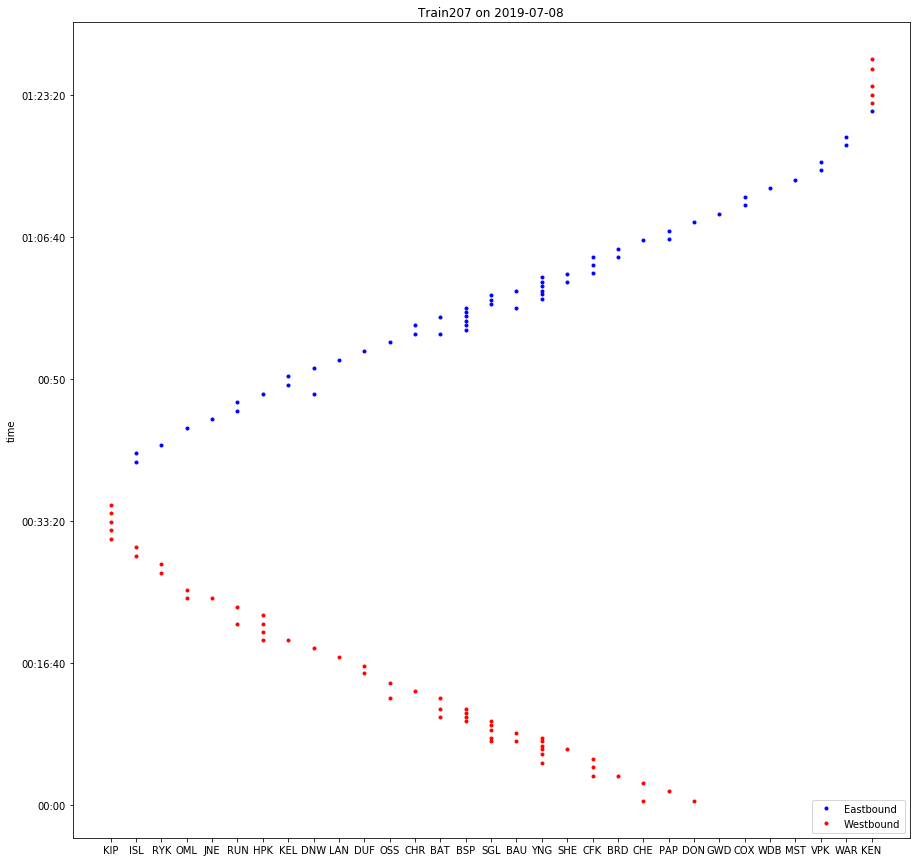

In [16]:
plt.figure(figsize=(15, 15))
train = 207;
day = datetime.date(2019,7,8);
plt.plot(merged[(merged['trainid'] == train) & (merged['traindirection'] == 'East') &
                (merged['date'] == day)]['stationid'],
        merged[(merged['trainid'] == train) & (merged['traindirection'] == 'East') &
                (merged['date'] == day)]['time'],'b.', label='Eastbound')

plt.plot(merged[(merged['trainid'] == train) & (merged['traindirection'] == 'West') &
                (merged['date'] == day)]['stationid'],
        merged[(merged['trainid'] == train) & (merged['traindirection'] == 'West') &
                (merged['date'] == day)]['time'],'r.', label='Westbound')
plt.xticks(merged['stationid'].unique(), merged['station_char'].unique())
plt.title('Train'+str(train)+' on '+str(day))
plt.legend(loc='lower right')
plt.show()

In [17]:
# Data in the graph
# Eastbound
merged[(merged['trainid'] == train) & (merged['traindirection'] == 'East') & (merged['date'] == day)]

,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,stationid,lineid,create_date,pollid,request_date,date,time
39263,9152,31853754410,ISL,BD,0.759364,East,207,Arriving,Westbound<br/> To Kipling,34,2,2019-07-08 00:40:16,141,2019-07-08 00:40:17.275246-04:00,2019-07-08,00:40:17.275246
38872,9080,31853774816,ISL,BD,0.000000,East,207,AtStation,Westbound<br/> To Kipling,34,2,2019-07-08 00:41:16,140,2019-07-08 00:41:16.874795-04:00,2019-07-08,00:41:16.874795
38478,9009,31853796235,RYK,BD,0.621544,East,207,Arriving,Westbound<br/> To Kipling,35,2,2019-07-08 00:42:16,139,2019-07-08 00:42:17.288056-04:00,2019-07-08,00:42:17.288056
37713,8866,31853836492,OML,BD,0.260209,East,207,Arriving,Westbound<br/> To Kipling,36,2,2019-07-08 00:44:16,137,2019-07-08 00:44:17.542968-04:00,2019-07-08,00:44:17.542968
37327,8796,31853859378,JNE,BD,0.907627,East,207,Arriving,Westbound<br/> To Kipling,37,2,2019-07-08 00:45:17,136,2019-07-08 00:45:18.284426-04:00,2019-07-08,00:45:18.284426
36931,8725,31853881084,RUN,BD,0.872236,East,207,Arriving,Westbound<br/> To Kipling,38,2,2019-07-08 00:46:17,135,2019-07-08 00:46:18.524023-04:00,2019-07-08,00:46:18.524023
36535,8653,31853902162,RUN,BD,0.000000,East,207,AtStation,Westbound<br/> To Kipling,38,2,2019-07-08 00:47:16,134,2019-07-08 00:47:16.628391-04:00,2019-07-08,00:47:16.628391
36150,8582,31853924515,HPK,BD,0.000000,East,207,AtStation,Westbound<br/> To Kipling,39,2,2019-07-08 00:48:16,133,2019-07-08 00:48:17.431969-04:00,2019-07-08,00:48:17.431969
36160,8584,31853924869,DNW,BD,1.711106,East,207,Arriving,Westbound<br/> To Kipling,41,2,2019-07-08 00:48:17,133,2019-07-08 00:48:17.961763-04:00,2019-07-08,00:48:17.961763
35779,8511,31853946410,KEL,BD,0.689469,East,207,Arriving,Westbound<br/> To Kipling,40,2,2019-07-08 00:49:15,132,2019-07-08 00:49:17.297205-04:00,2019-07-08,00:49:17.297205


In [18]:
# Data in the graph
# Westbound
merged[(merged['trainid'] == train) & (merged['traindirection'] == 'West') & (merged['date'] == day)]

,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,stationid,lineid,create_date,pollid,request_date,date,time
54717,12038,31852942473,CHE,BD,1.477567,West,207,Arriving,Eastbound<br/> To Kennedy,54,2,2019-07-08 00:00:29,181,2019-07-08 00:00:30.301021-04:00,2019-07-08,00:00:30.301021
54729,12040,31852943107,DON,BD,0.000000,West,207,AtStation,Eastbound<br/> To Kennedy,56,2,2019-07-08 00:00:30,181,2019-07-08 00:00:31.149566-04:00,2019-07-08,00:00:31.149566
54350,11968,31852967291,PAP,BD,0.000000,West,207,AtStation,Eastbound<br/> To Kennedy,55,2,2019-07-08 00:01:37,180,2019-07-08 00:01:38.863220-04:00,2019-07-08,00:01:38.863220
53961,11897,31852985309,CHE,BD,0.000000,West,207,AtStation,Eastbound<br/> To Kennedy,54,2,2019-07-08 00:02:33,179,2019-07-08 00:02:35.574802-04:00,2019-07-08,00:02:35.574802
53569,11824,31853001787,CFK,BD,1.551256,West,207,Arriving,Eastbound<br/> To Kennedy,52,2,2019-07-08 00:03:23,178,2019-07-08 00:03:24.470186-04:00,2019-07-08,00:03:24.470186
53575,11825,31853002264,BRD,BD,0.428792,West,207,Arriving,Eastbound<br/> To Kennedy,53,2,2019-07-08 00:03:24,178,2019-07-08 00:03:25.017248-04:00,2019-07-08,00:03:25.017248
53181,11752,31853021644,CFK,BD,1.105464,West,207,Arriving,Eastbound<br/> To Kennedy,52,2,2019-07-08 00:04:27,177,2019-07-08 00:04:28.723510-04:00,2019-07-08,00:04:28.723510
52619,11646,31853031624,YNG,BD,1.838529,West,207,Arriving,Westbound<br/> To Kipling,50,1,2019-07-08 00:04:56,176,2019-07-08 00:04:56.534318-04:00,2019-07-08,00:04:56.534318
52792,11680,31853041038,CFK,BD,0.000000,West,207,AtStation,Eastbound<br/> To Kennedy,52,2,2019-07-08 00:05:24,176,2019-07-08 00:05:26.781496-04:00,2019-07-08,00:05:26.781496
52249,11576,31853051379,YNG,BD,1.420773,West,207,Arriving,Westbound<br/> To Kipling,50,1,2019-07-08 00:05:56,175,2019-07-08 00:05:56.993629-04:00,2019-07-08,00:05:56.993629
